In [0]:
import os

import requests
import datetime
import json

import pandas as pd
%matplotlib inline

from pandas.io.json import json_normalize
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from newsapi.newsapi_client import NewsApiClient
from datetime import date, datetime, timedelta



In [279]:
!pip install ibm_watson
!pip install newsapi-python

import nltk
nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer()

# News Headlines Sentiment

Use the news api to pull the latest news articles for bitcoin and ethereum and create a DataFrame of sentiment scores for each coin. 

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [281]:
# Read your api key environment variable
news_key = "c06c0464414f49509614ace00566783c"


print(len(news_key))

32


In [0]:
# Create a newsapi client
articles = NewsApiClient(news_key)


In [283]:
# Date parameters
current_date = date.today()
date = current_date
past_date = date.today() - timedelta(weeks=4)

print(f"""
start date: {past_date}

end date: {current_date}
"""
)


start date: 2020-03-03

end date: 2020-03-31



In [0]:
# Fetch the Bitcoin news articles

Btc_headlines = articles.get_everything(
    q='bitcoin',
    language='en',
    from_param=str(past_date),
    to=str(date),
    sort_by='relevancy')

In [0]:
# Fetch the Ethereum news articles
eth_headlines = articles.get_everything(
    q='ethereum',
    language='en',
    from_param=str(past_date),
            to=str(date),
    sort_by='relevancy'
)
Btc_headlines

In [0]:
#Set up a pickle
import pickle

In [287]:
# How many articles
print(f"Total mentions of Bitcoin: {Btc_headlines['totalResults']}")

Total mentions of Bitcoin: 3292


In [288]:
# How many articles

print(f"Total mentions of Ethereum: {eth_headlines['totalResults']}")



Total mentions of Ethereum: 715


In [0]:
# intialize a sentiment analyzer object
sid = SentimentIntensityAnalyzer()

In [0]:
# Create function that computes average compound sentiment of headlines for each day

Btc_sentiment = []

for article in Btc_headlines["articles"]:
    try:
        date = article["publishedAt"][:10]
        text = article["content"]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        
        Btc_sentiment.append({
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu,
            "text": text
            
        })
        
    except AttributeError:
        pass

In [0]:
eth_sentiment = []    

for article in eth_headlines["articles"]:
    try:
        date = article["publishedAt"][:10]
        text = article["content"]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        
        eth_sentiment.append({
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu,
            "text": text
            
        })
        
    except AttributeError:
        pass

In [292]:
# Create the Bitcoin sentiment scores DataFrame

Btc_df = pd.DataFrame(Btc_sentiment)
Btc_df.to_pickle('Btc_df.mypickle')
Btc_df.head()

,date,compound,positive,negative,neutral,text
0,2020-03-12,-0.2944,0.074,0.078,0.847,Bitcoin is going through a remarkably bad day....
1,2020-03-04,0.0000,0.000,0.000,1.000,After launching two cryptocurrency-oriented sm...
2,2020-03-04,-0.5106,0.103,0.168,0.730,Indias Supreme Court on Wednesday overturned c...
3,2020-03-19,0.5070,0.068,0.000,0.932,Our robot colleague Satoshi Nakaboto writes ab...
4,2020-03-23,0.7893,0.137,0.000,0.863,Our robot colleague Satoshi Nakaboto writes ab...


In [293]:
# Create the ethereum sentiment scores DataFrame

eth_df = pd.DataFrame(eth_sentiment)
eth_df.to_pickle('Btc_df.mypickle')
eth_df.head()

,date,compound,positive,negative,neutral,text
0,2020-03-12,-0.2944,0.074,0.078,0.847,Bitcoin is going through a remarkably bad day....
1,2020-03-06,0.0000,0.000,0.000,1.000,If a player picks up an item in an online vide...
2,2020-03-24,0.8176,0.179,0.000,0.821,Web browser Brave is expanding its cryptocurre...
3,2020-03-17,-0.1027,0.000,0.035,0.965,"Coinbase Card, the Visa debit card that lets y..."
4,2020-03-05,0.4019,0.068,0.000,0.932,The South Korean National Assembly passed new ...


In [294]:
# Describe the Bitcoin Sentiment
Btc_df.describe()

,compound,positive,negative,neutral
count,19.000000,19.000000,19.000000,19.000000
mean,0.368705,0.077842,0.022842,0.899316
std,0.341282,0.032196,0.043031,0.055531
min,-0.510600,0.000000,0.000000,0.730000
25%,0.267050,0.066500,0.000000,0.870000
50%,0.507000,0.068000,0.000000,0.915000
75%,0.507000,0.079500,0.042000,0.932000
max,0.789300,0.137000,0.168000,1.000000


In [295]:
# Describe the Ethereum Sentiment
eth_df.describe()

,compound,positive,negative,neutral
count,19.000000,19.000000,19.000000,19.000000
mean,0.165547,0.068632,0.035368,0.896000
std,0.486744,0.068825,0.046570,0.070055
min,-0.717400,0.000000,0.000000,0.762000
25%,-0.051350,0.000000,0.000000,0.843000
50%,0.340000,0.068000,0.000000,0.899000
75%,0.459300,0.101500,0.059000,0.933500
max,0.895500,0.208000,0.133000,1.000000


### Questions:

Q: Which coin had the highest mean positive score?

A: Bitcoin

Q: Which coin had the highest compound score?

A: Bitcoin

Q. Which coin had the highest positive score?

A: Bitcoin (question seems redundant)

---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [0]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [297]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [298]:

# Create a variable for Stopwords

sw = stopwords.words('english')
print(len(sw))

# Expand the default stopwords list if necessary
sw.extend(['subject', 'use','re','item','let','char'])
print(len(sw))

# NLTK list of stopwords

print(sw)


179
185
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', '

In [0]:
wnl = WordNetLemmatizer()

# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
     
    # Create a list of the words
    words = word_tokenize(text)
    
    # Convert the words to lowercase
    # Remove the punctuation
    # Remove the stop words
    lower_case = [word.lower() for word in words if word.lower() not in sw and word.lower() 
                  not in punctuation]
    
    # Lemmatize Words into root words
    tokens = [wnl.lemmatize(word) for word in lower_case]
    
    return (tokens)



In [300]:
# Create a new tokens column for Bitcoin
Btc_df['token']= Btc_df.text.apply(tokenizer)
Btc_df.head()


,date,compound,positive,negative,neutral,text,token
0,2020-03-12,-0.2944,0.074,0.078,0.847,Bitcoin is going through a remarkably bad day....,"[bitcoin, going, remarkably, bad, day, turn, a..."
1,2020-03-04,0.0000,0.000,0.000,1.000,After launching two cryptocurrency-oriented sm...,"[launching, two, cryptocurrency-oriented, smar..."
2,2020-03-04,-0.5106,0.103,0.168,0.730,Indias Supreme Court on Wednesday overturned c...,"[india, supreme, court, wednesday, overturned,..."
3,2020-03-19,0.5070,0.068,0.000,0.932,Our robot colleague Satoshi Nakaboto writes ab...,"[robot, colleague, satoshi, nakaboto, writes, ..."
4,2020-03-23,0.7893,0.137,0.000,0.863,Our robot colleague Satoshi Nakaboto writes ab...,"[robot, colleague, satoshi, nakaboto, writes, ..."


In [301]:
# Create a new tokens column for ethereum
eth_df['token']= eth_df.text.apply(tokenizer)
eth_df.head()

,date,compound,positive,negative,neutral,text,token
0,2020-03-12,-0.2944,0.074,0.078,0.847,Bitcoin is going through a remarkably bad day....,"[bitcoin, going, remarkably, bad, day, turn, a..."
1,2020-03-06,0.0000,0.000,0.000,1.000,If a player picks up an item in an online vide...,"[player, pick, online, video, game, owns, play..."
2,2020-03-24,0.8176,0.179,0.000,0.821,Web browser Brave is expanding its cryptocurre...,"[web, browser, brave, expanding, cryptocurrenc..."
3,2020-03-17,-0.1027,0.000,0.035,0.965,"Coinbase Card, the Visa debit card that lets y...","[coinbase, card, visa, debit, card, let, spend..."
4,2020-03-05,0.4019,0.068,0.000,0.932,The South Korean National Assembly passed new ...,"[south, korean, national, assembly, passed, ne..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [0]:
from collections import Counter
from nltk import ngrams

lemmatizer = WordNetLemmatizer()

In [0]:


def process_text(text):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw and 
              word.lower() not in punctuation]
    return output


In [0]:
# get word counts
def word_counter(articles): 
    # Combine all articles in corpus into one large string
    big_string = ' '.join(articles)
    processed = process_text(big_string)
    top_10 = dict(Counter(processed).most_common(10))
    return pd.DataFrame(list(top_10.items()), columns=['word', 'count'])


In [305]:
#Bitcoin word counter
word_counter(Btc_df['text'])

,word,count
0,bitcoin,44
1,satoshi,28
2,nakaboto,28
3,char,19
4,going,15
5,hour,15
6,today,15
7,btc,14
8,robot,14
9,colleague,14


In [327]:
#Ethereum word counter
word_counter(eth_df['text'])

,word,count
0,char,19
1,cryptocurrency,10
2,bitcoin,8
3,company,6
4,first,5
5,today,5
6,fell,5
7,ethereum,5
8,wa,4
9,user,4


In [0]:
#Make text into a string
Btc_text = Btc_df['text']
Btc_token = ''
for i in Btc_text:
   Btc_token += str(i)

eth_text = eth_df['text']
eth_token = ''
for i in eth_text:
   eth_token += str(i)

def bigram_counter(text): 
    
    bigrams = ngrams(text, n=2)
    
    return Counter(ngrams(text, n=2))
    

In [307]:
# Generate the Bitcoin N-grams where N=2
Btc_tokenized = tokenizer(Btc_token)
bigram_counter(Btc_tokenized)

Counter({('+1146', 'char'): 1,
         ('+1156', 'char'): 1,
         ('+1336', 'char'): 1,
         ('+2230', 'char'): 1,
         ('+2878', 'char'): 1,
         ('+2889', 'char'): 1,
         ('+2892', 'char'): 1,
         ('+2896', 'char'): 2,
         ('+2955', 'char'): 1,
         ('+2971', 'char'): 1,
         ('+2973', 'char'): 1,
         ('+3048', 'char'): 1,
         ('+3054', 'char'): 1,
         ('+3077', 'char'): 1,
         ('+3088', 'char'): 1,
         ('+3119', 'char'): 1,
         ('+3163', 'char'): 1,
         ('+3308', 'char'): 1,
         ('1', '2020'): 1,
         ('1', 'btc'): 1,
         ('1', 'company'): 1,
         ('1', 'exodus'): 1,
         ('15', '20'): 1,
         ('20', 'minute'): 1,
         ('2018', 'barred'): 1,
         ('2020', 'role'): 1,
         ('24', 'hour'): 14,
         ('5g', 'hub'): 1,
         ('5g', 'router'): 1,
         ('7,250', 'across'): 1,
         ('across', '…'): 1,
         ('add', 'mi…'): 1,
         ('ago', 'average'): 1,
    

In [308]:
# Generate the Ethereum N-grams where N=2
eth_tokenized = tokenizer(eth_token)
bigram_counter(eth_tokenized)

Counter({("'re", 'raising'): 1,
         ("'s", 'financial'): 1,
         ("'s", 'hottest'): 1,
         ('+0.73', 'recently'): 1,
         ('+1000', 'char'): 1,
         ('+1146', 'char'): 1,
         ('+12437', 'char'): 1,
         ('+1292', 'char'): 1,
         ('+1838', 'char'): 1,
         ('+1890', 'char'): 1,
         ('+2003', 'char'): 1,
         ('+2024', 'char'): 1,
         ('+2579', 'char'): 1,
         ('+2713', 'char'): 1,
         ('+28', 'char'): 1,
         ('+2878', 'char'): 1,
         ('+2971', 'char'): 1,
         ('+4339', 'char'): 1,
         ('+5858', 'char'): 1,
         ('+6101', 'char'): 1,
         ('+900', 'char'): 1,
         ('+932', 'char'): 2,
         ('--', 'first'): 1,
         ('--', 'letting'): 1,
         ('...', "'re"): 1,
         ('...', 'watch'): 1,
         ('//academy.ivanontech.com/webinarsign', 'telegram'): 1,
         ('//ivanontech.com/livesign', 'webinar'): 1,
         ('//pawnhub.io/select-registratio', '...'): 1,
         ('//www.bid

In [0]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [310]:
# Get the top 10 words for Bitcoin
token_count(Btc_tokenized)

[('bitcoin', 44),
 ('satoshi', 28),
 ('nakaboto', 28),
 ('char', 19),
 ('going', 15),
 ('day', 15),
 ('hour', 15),
 ('today', 15),
 ('btc', 14),
 ('robot', 14)]

In [311]:
# Get the top 10 words for Ethereum
token_count(eth_tokenized)

[('char', 19),
 ('bitcoin', 11),
 ('cryptocurrency', 10),
 ('company', 6),
 ('first', 5),
 ('today', 5),
 ('fell', 5),
 ('ethereum', 5),
 ('user', 4),
 ('new', 4)]

# Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]
import spacy

nlp = spacy.load("en_core_web_sm")

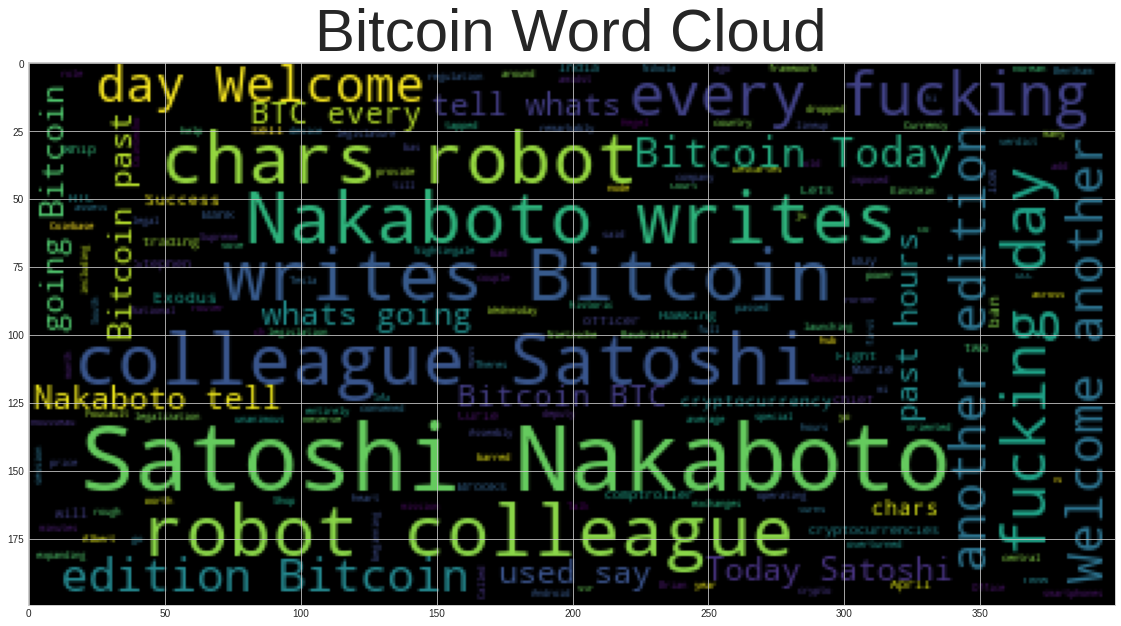

In [313]:
# Generate the Bitcoin word cloud

#make a variable and fill it with words
wc_xbt = WordCloud().generate(Btc_token)
plt.title("Bitcoin Word Cloud",fontsize=60)
plt.imshow(wc_xbt)

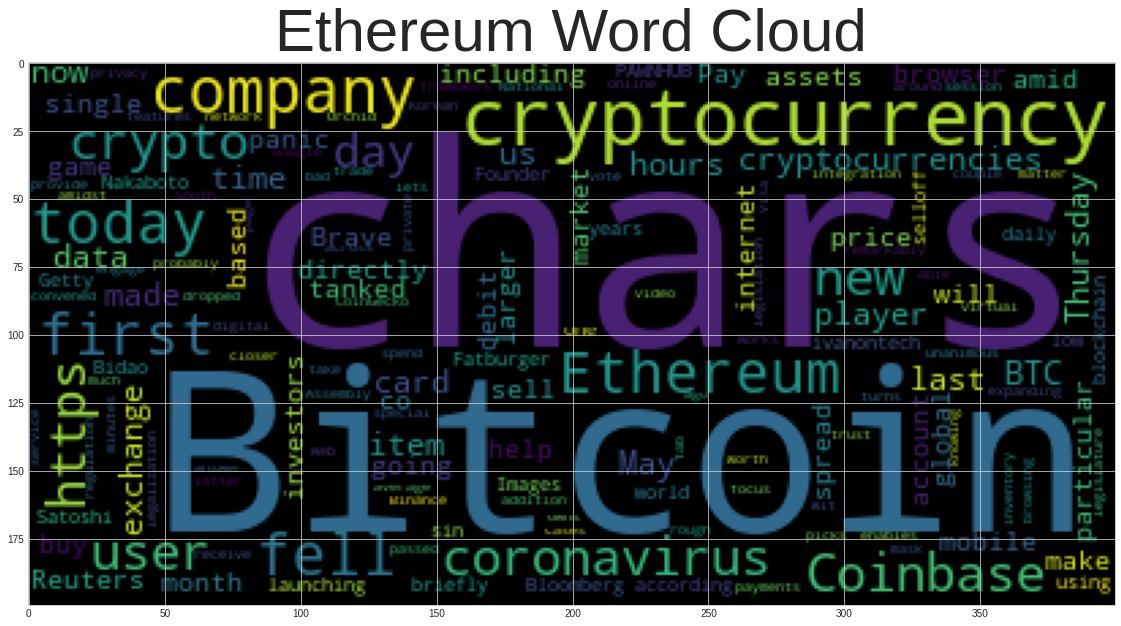

In [314]:
# Generate the Ethereum word cloud
wc_xbt = WordCloud().generate(eth_token)
plt.title("Ethereum Word Cloud",fontsize=60)
plt.imshow(wc_xbt)

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

In [0]:
import spacy
from spacy import displacy
import spacy
from nltk.corpus import reuters
from spacy import displacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt 



In [0]:
# Optional - download a language model for SpaCy
!python -m spacy download en_core_web_sm

In [0]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Bitcoin NER

In [318]:
# Concatenate all of the bitcoin text together
joined_btc = ''.join(Btc_df['text'])
joined_btc

'Bitcoin is going through a remarkably bad day. It turns out all assets are having a rough month including cryptocurrencies. A couple of hours ago, the average price of BTC dropped by 15% in just 20 minutes.\r\nOn CoinGecko, 1 BTC was worth around $7,250 across … [+1146 chars]After launching two cryptocurrency-oriented smartphones, the HTC Exodus 1 and the Exodus 1s, the company is expanding the lineup with an entirely new device: a 5G router that can function as a full Bitcoin node.\xa0\r\nCalled the HTC Exodus 5G hub, the Android-bas… [+2230 chars]Indias Supreme Court on Wednesday overturned\xa0central banks two-year-old ban on cryptocurrency trading in the country in what many said was a historic verdict.\r\nThe Reserve Bank of India had imposed a ban on cryptocurrency trading in April 2018 that barred ban… [+1336 chars]Our robot colleague Satoshi Nakaboto writes about Bitcoin every fucking day.\r\nWelcome to another edition of Bitcoin Today, where I, Satoshi Nakaboto, tell you what

In [328]:
# Run the NER processor on all of the text
doc = nlp(joined_btc)
for ent in doc.ents: 
    print(ent.text, ent.label_) 
# Add a title to the document

doc.user_data["title"] = "Bitcoin NER"


ERROR! Session/line number was not unique in database. History logging moved to new session 80
Bitcoin GPE
A couple of hours ago TIME
BTC ORG
15% PERCENT
just 20 minutes TIME
CoinGecko PRODUCT
1 CARDINAL
BTC ORG
around $7,250 MONEY
two CARDINAL
HTC Exodus 1 PRODUCT
Exodus WORK_OF_ART
5 CARDINAL
Bitcoin GPE
HTC Exodus 5 PRODUCT
Android-bas GPE
Supreme Court ORG
Wednesday DATE
two-year-old DATE
The Reserve Bank of India ORG
April 2018 DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
Bitcoin GPE
Today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
the past 24 hours TIME
Descartes PERSON
Satoshi Nakaboto PERSON
Bitcoin GPE
Bitcoin GPE
Today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
the past 24 hours TIME
Nikola Tesla ORG
Success ORG
Brian Brooks PERSON
first ORDINAL
the Office of the Comptroller of the Currency ORG
April 1, 2020 DATE
Brooks ORG
OCC ORG
chars]The South Korean National Assembly ORG
today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
Bitcoin GPE
Today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
the

In [320]:
# Render the visualization
displacy.render(doc, style='ent',jupyter=True)

In [321]:
# List all Entities
doc = nlp(joined_btc)
for ent in doc.ents: 
    print(ent.text, ent.label_) 
doc.user_data["title"] = "Bitcoin NER"


Bitcoin GPE
A couple of hours ago TIME
BTC ORG
15% PERCENT
just 20 minutes TIME
CoinGecko PRODUCT
1 CARDINAL
BTC ORG
around $7,250 MONEY
two CARDINAL
HTC Exodus 1 PRODUCT
Exodus WORK_OF_ART
5 CARDINAL
Bitcoin GPE
HTC Exodus 5 PRODUCT
Android-bas GPE
Supreme Court ORG
Wednesday DATE
two-year-old DATE
The Reserve Bank of India ORG
April 2018 DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
Bitcoin GPE
Today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
the past 24 hours TIME
Descartes PERSON
Satoshi Nakaboto PERSON
Bitcoin GPE
Bitcoin GPE
Today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
the past 24 hours TIME
Nikola Tesla ORG
Success ORG
Brian Brooks PERSON
first ORDINAL
the Office of the Comptroller of the Currency ORG
April 1, 2020 DATE
Brooks ORG
OCC ORG
chars]The South Korean National Assembly ORG
today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
Bitcoin GPE
Today DATE
Satoshi Nakaboto PERSON
Bitcoin GPE
the past 24 hours TIME
Stephen Hawking PERSON
Satoshi Nakaboto PERSON
Bitcoin GPE
Bitcoin GPE
Toda

---

## Ethereum NER

In [322]:
# Concatenate all of the bitcoin text together
joined_eth = ''.join(eth_df['text'])
joined_eth

"Bitcoin is going through a remarkably bad day. It turns out all assets are having a rough month including cryptocurrencies. A couple of hours ago, the average price of BTC dropped by 15% in just 20 minutes.\r\nOn CoinGecko, 1 BTC was worth around $7,250 across … [+1146 chars]If a player picks up an item in an online video game, who owns that item? The player, or the company that made the game?\r\nIn most cases, the answer is probably closer to the latter. The item may be in the players digital inventory – but the company can take i… [+2713 chars]Web browser Brave is expanding its cryptocurrency features with an integration with cryptocurrency exchange Binance. Brave users will be able to buy, trade and receive crypto assets directly on the new tab page.\r\nIn addition to a particular focus on privacy, … [+1292 chars]Coinbase Card, the Visa debit card that lets you spend cryptocurrency directly from your Coinbase account, now works with Google Pay.\xa0\r\nThis makes Coinbase, a U.S.-ba

In [323]:
# Run the NER processor on all of the text
doc = nlp(joined_eth)
for ent in doc.ents: 
    print(ent.text, ent.label_) 
# Add a title to the document

doc.user_data["title"] = "Ethereum NER"

Bitcoin GPE
A couple of hours ago TIME
BTC ORG
15% PERCENT
just 20 minutes TIME
CoinGecko PRODUCT
1 CARDINAL
BTC ORG
around $7,250 MONEY
Brave PRODUCT
Visa ORG
Google Pay ORG
Coinbase PRODUCT
first ORDINAL
chars]The South Korean National Assembly ORG
today DATE
Thursday DATE
6,000 MONEY
first ORDINAL
May DATE
as low as $5,705.31 MONEY
Bloomberg ORG
Thursday DATE
6,000 MONEY
first ORDINAL
May DATE
as low as $5,705.31 MONEY
Bloomberg ORG
one CARDINAL
Europe LOC
U.S. GPE
London GPE
chars]7 PRODUCT
7 CARDINAL
one-day DATE
months DATE
Bitcoin GPE
21 percent PERCENT
the last 24 hours TIME
Earlier today TIME
Bitcoin GPE
6,000 MONEY
first ORDINAL
+1838 chars]Some Libra Association ORG
Andreessen Horowitz PERSON
today DATE
50 CARDINAL
The Celo Foundation ORG
‘Alliance For Prosperity’ ORG
Camila Russo PERSON
Building the Next Internet with Ethereum WORK_OF_ART
Vitalik Buterin and PERSON
Jul PERSON
Thursday DATE
bitcoin GPE
26% PERCENT
daily DATE
seven years DATE
5,700 MONEY
Satoshi Nakaboto PERS

In [324]:
# Render the visualization
displacy.render(doc, style='ent',jupyter=True)

In [325]:
# List all Entities
doc = nlp(joined_eth)
for ent in doc.ents: 
    print(ent.text, ent.label_) 

Bitcoin GPE
A couple of hours ago TIME
BTC ORG
15% PERCENT
just 20 minutes TIME
CoinGecko PRODUCT
1 CARDINAL
BTC ORG
around $7,250 MONEY
Brave PRODUCT
Visa ORG
Google Pay ORG
Coinbase PRODUCT
first ORDINAL
chars]The South Korean National Assembly ORG
today DATE
Thursday DATE
6,000 MONEY
first ORDINAL
May DATE
as low as $5,705.31 MONEY
Bloomberg ORG
Thursday DATE
6,000 MONEY
first ORDINAL
May DATE
as low as $5,705.31 MONEY
Bloomberg ORG
one CARDINAL
Europe LOC
U.S. GPE
London GPE
chars]7 PRODUCT
7 CARDINAL
one-day DATE
months DATE
Bitcoin GPE
21 percent PERCENT
the last 24 hours TIME
Earlier today TIME
Bitcoin GPE
6,000 MONEY
first ORDINAL
+1838 chars]Some Libra Association ORG
Andreessen Horowitz PERSON
today DATE
50 CARDINAL
The Celo Foundation ORG
‘Alliance For Prosperity’ ORG
Camila Russo PERSON
Building the Next Internet with Ethereum WORK_OF_ART
Vitalik Buterin and PERSON
Jul PERSON
Thursday DATE
bitcoin GPE
26% PERCENT
daily DATE
seven years DATE
5,700 MONEY
Satoshi Nakaboto PERS